In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf

from tb import TB300
from tb_utils import BBoxUtility, loadWeightsFromNumpy

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.90
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
NUM_CLASSES = 2

In [3]:
input_shape=(700, 700, 3)
image_size = (input_shape[0], input_shape[1])
model = TB300(input_shape, num_classes=NUM_CLASSES)
loadWeightsFromNumpy(model, 'TextBoxes_icdar13.npy')
# model.load_weights('weights_opt_1.hdf5', by_name=True)
#loadWeightsFromNumpy(model, 'opt3.npy')

(None, 129020, 8)


In [3]:
input_shape = [(300, 300, 3), (700, 700, 3), (700, 300, 3), (700, 500, 3), (1600, 1600, 3)]
#input_shape=[(700, 700, 3)]
model = [TB300(x, num_classes=NUM_CLASSES) for x in input_shape]
for m in model:
    #loadWeightsFromNumpy(m, 'TextBoxes_icdar13.npy')
    #m.load_weights('weights_opt_1.hdf5', by_name=True)
    loadWeightsFromNumpy(m, 'opt4_700_300_300_700_700.npy')
    print "weights loaded"

(None, 24272, 8)
(None, 129020, 8)
(None, 55948, 8)
(None, 92750, 8)
(None, 666130, 8)
weights loaded
weights loaded
weights loaded
weights loaded
weights loaded


In [4]:
def prepareImg(imgPaths):
    inputs = [[] for _ in range(5)]
    images = []
    for f in imgPaths:
        images.append(imread(f))
    for shape,index in zip(input_shape,range(len(input_shape))):
        image_size = (shape[0], shape[1])
        for f in imgPaths:
            img = image.load_img(f, target_size=image_size)
            img = image.img_to_array(img)
            inputs[index].append(img.copy())
        inputs[index] = preprocess_input(np.array(inputs[index]))
    return inputs, images
def genFileList(prefix, suffix, start, end):
    return [prefix+str(x)+'.'+suffix for x in range(start, end)]

In [5]:
bbox_util = BBoxUtility(NUM_CLASSES)

In [6]:
fileList = genFileList('./icdar/test_imgs/img_','jpg',1,10)
inputs, images = prepareImg(fileList)

In [7]:
bbox_util.nms_thresh = 0.45

In [8]:
%%time
det = [bbox_util.detection_out(model[i].predict(inputs[i], batch_size=1, verbose=1),0) for i in range(len(model))]

9/9 [==============================] - 19s    
CPU times: user 21.4 s, sys: 3.46 s, total: 24.9 s
Wall time: 34.6 s


In [9]:
bbox_util.nms_thresh = 0.25

In [10]:
results = bbox_util.multiScaleOutput(det)
#results = bbox_util.combineMultiScaleOutput(det)

In [10]:
inputs = []
images = []
img_path = './icdar/test_imgs/img_111.jpg'
img = image.load_img(img_path, target_size=image_size)
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = './icdar/test_imgs/img_112.jpg'
img = image.load_img(img_path, target_size=image_size)
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = './icdar/test_imgs/img_113.jpg'
img = image.load_img(img_path, target_size=image_size)
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = './icdar/test_imgs/img_114.jpg'
img = image.load_img(img_path, target_size=image_size)
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = './icdar/test_imgs/img_115.jpg'
img = image.load_img(img_path, target_size=image_size)
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [11]:
preds = model.predict(inputs, batch_size=1, verbose=1)

5/5 [==============================] - 1s     


In [6]:
bbox_util = BBoxUtility(NUM_CLASSES)

In [12]:
results = bbox_util.detection_out(preds, 0)

In [8]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds, 1)

CPU times: user 27.9 s, sys: 1.94 s, total: 29.8 s
Wall time: 4.68 s


In [11]:
voc_classes = ['Text']

In [19]:
test_list = open('./icdar/icdar_results/test_lists.txt', 'w')
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]
    
    # Get detections with confidence higher than 0.6.
    top_indices = [j for j, conf in enumerate(det_conf) if conf >= 0.9]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    fig = plt.figure()
    plt.imshow(img / 255.)
    currentAxis = plt.gca()
    imgFile = fileList[i].split('/')[-1]
    test_list.write(imgFile)
    test_list.write('\n')
    dt = open('./icdar/icdar_results/dt/' + imgFile.split('.')[0] + '.txt', 'w')
    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        dt.write('%f %d %d %d %d\n' % (score, xmin, ymin, xmax, ymax))
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}'.format(score)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.savefig('./icdar/icdar_results/test_results/' + imgFile.split('.')[0] + '.jpg')
    plt.close(fig)
    dt.close()
    print imgFile + ' processed complete'
test_list.close()

img_1.jpgprocessed complete
img_2.jpgprocessed complete
img_3.jpgprocessed complete
img_4.jpgprocessed complete
img_5.jpgprocessed complete
img_6.jpgprocessed complete
img_7.jpgprocessed complete
img_8.jpgprocessed complete
img_9.jpgprocessed complete
img_10.jpgprocessed complete
img_11.jpgprocessed complete
img_12.jpgprocessed complete
img_13.jpgprocessed complete
img_14.jpgprocessed complete
img_15.jpgprocessed complete
img_16.jpgprocessed complete
img_17.jpgprocessed complete
img_18.jpgprocessed complete
img_19.jpgprocessed complete
img_20.jpgprocessed complete
img_21.jpgprocessed complete
img_22.jpgprocessed complete
img_23.jpgprocessed complete
img_24.jpgprocessed complete
img_25.jpgprocessed complete
img_26.jpgprocessed complete
img_27.jpgprocessed complete
img_28.jpgprocessed complete
img_29.jpgprocessed complete
img_30.jpgprocessed complete
img_31.jpgprocessed complete
img_32.jpgprocessed complete
img_33.jpgprocessed complete
img_34.jpgprocessed complete
img_35.jpgprocessed com

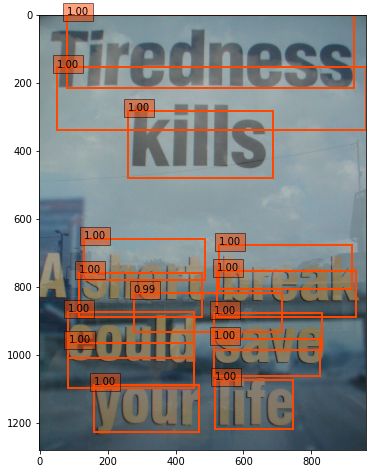

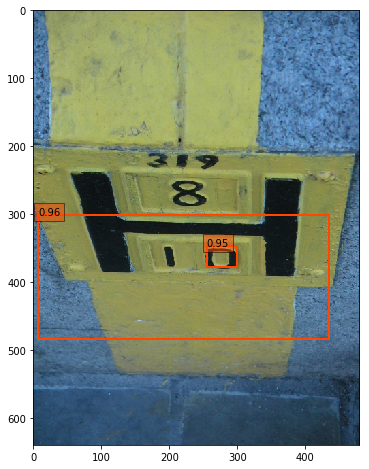

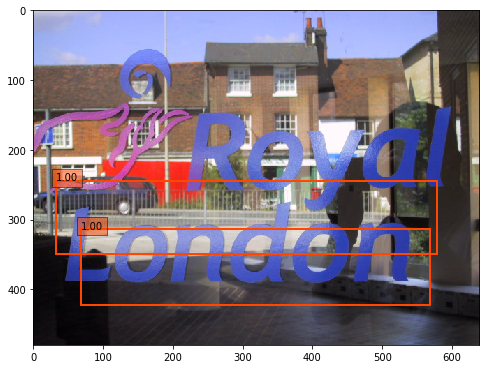

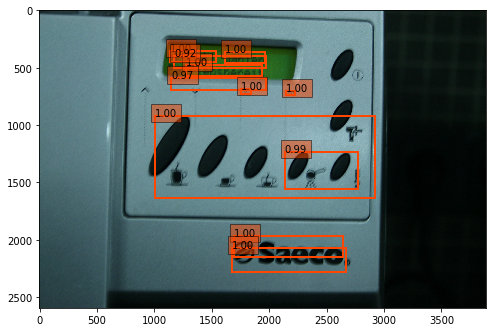

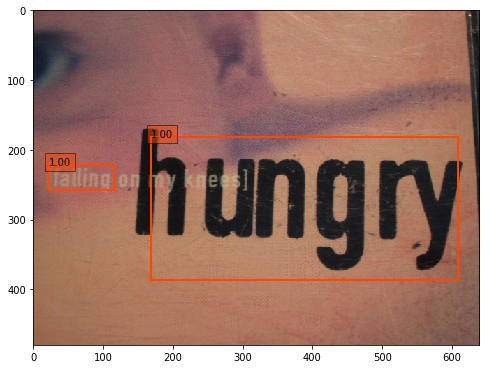

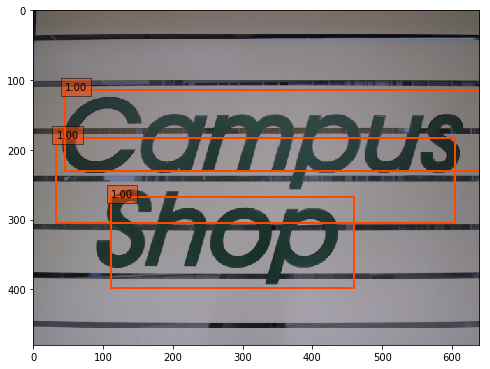

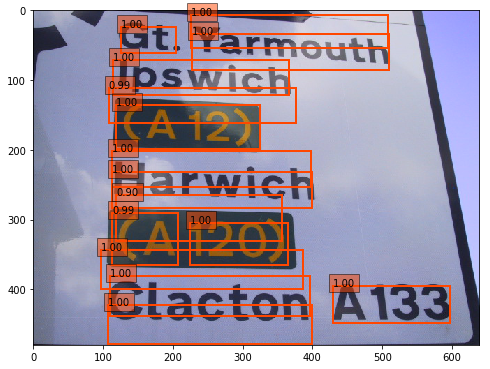

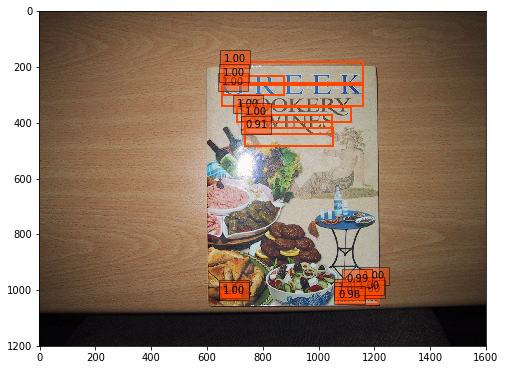

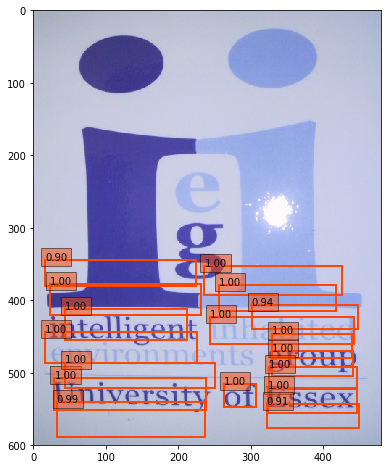

In [12]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]
    
    # Get detections with confidence higher than 0.6.
    top_indices = [j for j, conf in enumerate(det_conf) if conf >= 0.9]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(img / 255.)
    currentAxis = plt.gca()
    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}'.format(score)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()